In [1]:

%load_ext autoreload
%autoreload 2
from keras.applications.vgg16 import VGG16
from keras.models import Model,Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import GRU
from keras.layers.core import Reshape,Dense,Flatten,Permute,Lambda,Activation
from keras.layers.wrappers import Bidirectional,TimeDistributed
from keras.layers import Input
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras import regularizers 
import tensorflow as tf 
from keras.callbacks import EarlyStopping,ModelCheckpoint,Callback

def rpn_loss_regr(y_true,y_pred):
    """
    smooth L1 loss
  
    y_ture [1][HXWX9][3] (class,regr)
    y_pred [1][HXWX9][2] (reger)
    """   
    
    sigma=9.0
    
    cls = y_true[0,:,0]
    regr = y_true[0,:,1:3]
    regr_keep = tf.where(K.equal(cls,1))[:,0]
    regr_true = tf.gather(regr,regr_keep)
    regr_pred = tf.gather(y_pred[0],regr_keep)
    diff = tf.abs(regr_true-regr_pred)
    less_one = tf.cast(tf.less(diff,1.0/sigma),'float32')
    loss = less_one * 0.5 * diff**2 * sigma   + tf.abs(1-less_one) * (diff -0.5/sigma)
    loss = K.sum(loss,axis=1)

    return K.switch(tf.size(loss)>0,K.mean(loss),K.constant(0.0))

def rpn_loss_cls(y_true,y_pred):
    """
    softmax loss
    
    y_true [1][1][HXWX9] class
    y_pred [1][HXWX9][2] class 
    """ 
    y_true = y_true[0][0]
    cls_keep = tf.where(tf.not_equal(y_true,-1))[:,0]
    cls_true = tf.gather(y_true,cls_keep)
    cls_pred = tf.gather(y_pred[0],cls_keep)
    cls_true = tf.cast(cls_true,'int64')
    #loss = K.sparse_categorical_crossentropy(cls_true,cls_pred,from_logits=True)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = cls_true,logits=cls_pred)
    return K.switch(tf.size(loss)>0,K.clip(K.mean(loss),0,10),K.constant(0.0))


def nn_base(input,trainable):
    base_model = VGG16(weights=None,include_top=False,input_shape = input)
    
    return base_model.input,base_model.get_layer('block5_conv3').output


def reshape(x):
    b = tf.shape(x)
    x = tf.reshape(x,[b[0]*b[1],b[2],b[3]])
    return x

def reshape2(x):
    x1,x2 = x
    b = tf.shape(x2)
    x = tf.reshape(x1,[b[0],b[1],b[2],256])
    return x 

def reshape3(x):
    b = tf.shape(x)
    x = tf.reshape(x,[b[0],b[1]*b[2]*10,2])
    return x 

def rpn(base_layers):
    
    x = Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',
               name='rpn_conv1')(base_layers)
    
    x1 = Lambda(reshape,output_shape=(None,512))(x) 
    
    x2 = Bidirectional(GRU(128,return_sequences=True),name='blstm')(x1)

    x3 = Lambda(reshape2,output_shape=(None,None,256))([x2,x])
    x3 = Conv2D(512,(1,1),padding='same',activation='relu',name='lstm_fc')(x3)

    cls = Conv2D(10*2,(1,1),padding='same',activation='linear',name='rpn_class')(x3)
    regr = Conv2D(10*2,(1,1),padding='same',activation='linear',name='rpn_regress')(x3)
    

    cls = Lambda(reshape3,output_shape=(None,2),name='rpn_class_reshape')(cls)
    cls_prod = Activation('softmax',name='rpn_cls_softmax')(cls)

    regr = Lambda(reshape3,output_shape=(None,2),name='rpn_regress_reshape')(regr)
    
    return cls,regr,cls_prod




import utils

utils.get_session(gpu_fraction=0.8)


Using TensorFlow backend.


In [2]:

inp,nn = nn_base((None,None,3),trainable=False)
cls,regr,cls_prod = rpn(nn)
basemodel =  Model(inp,[cls,regr,cls_prod])
basemodel.load_weights(r'E:\deeplearn\ctpn2018\model\weights-ctpnlstm-19.hdf5')






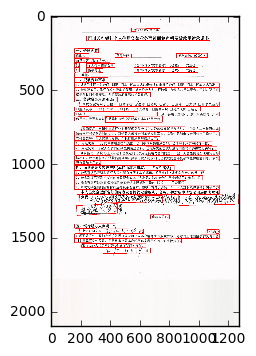

True

In [10]:
import cv2
import matplotlib.pyplot as plt 
import utils
from text_proposal_connector_oriented import TextProposalConnectorOriented
import numpy as np

imgpath = r'E:\deeplearn\OCRonline\chinese-ocr-demo\test\004.jpg'
#precess img
img = cv2.imread(imgpath)
h,w,c = img.shape
#zero-center by mean pixel 
m_img = img - utils.IMAGE_MEAN
m_img = np.expand_dims(m_img,axis=0)

cls,regr,cls_prod = basemodel.predict(m_img)


anchor = utils.gen_anchor((int(h/16),int(w/16)),16)

bbox = utils.bbox_transfor_inv(anchor,regr)
bbox = utils.clip_box(bbox,[h,w])

#score > 0.7
fg = np.where(cls_prod[0,:,1]>0.7)[0]
select_anchor = bbox[fg,:]
select_score = cls_prod[0,fg,1]
select_anchor = select_anchor.astype('int32')

#filter size
keep_index = utils.filter_bbox(select_anchor,16)


#nsm
select_anchor = select_anchor[keep_index]
select_score = select_score[keep_index]
select_score = np.reshape(select_score,(select_score.shape[0],1))
nmsbox = np.hstack((select_anchor,select_score))
keep = utils.nms(nmsbox,0.3)
select_anchor = select_anchor[keep]
select_score = select_score[keep]

#text line
textConn = TextProposalConnectorOriented()
text = textConn.get_text_lines(select_anchor,select_score,[h,w])

# for i in select_anchor:
#         cv2.rectangle(img,(i[0],i[1]),(i[2],i[3]),(255,0,0),2)

text= text.astype('int32')

for i in text:
    cv2.line(img,(i[0],i[1]),(i[2],i[3]),(255,0,0),2)
    cv2.line(img,(i[0],i[1]),(i[4],i[5]),(255,0,0),2)
    cv2.line(img,(i[6],i[7]),(i[2],i[3]),(255,0,0),2)
    cv2.line(img,(i[4],i[5]),(i[6],i[7]),(255,0,0),2)

plt.imshow(img)
plt.show()
cv2.imwrite(r'test\110.jpg',img)

In [11]:
text.shape


(19, 9)